In [21]:
# Librerias utilizadas en los codigos

from statsbombpy import sb
import pandas as pd
from mplsoccer import VerticalPitch,Pitch
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.patches import Rectangle, FancyBboxPatch, Circle, FancyArrowPatch
from collections import Counter
import textwrap
import os
import base64
import requests
from io import BytesIO
from dotenv import load_dotenv
from IPython.display import Image, display
from matplotlib.cm import get_cmap
from textwrap import fill
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle, FancyBboxPatch, FancyArrowPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
import matplotlib.image as mpimg

In [22]:
# Cargar los archivos necesarios
input_path = Path("../data") / "database_v5.csv"
df = pd.read_csv(input_path, low_memory=False)

In [28]:
# Cargar clave API desde .env
ruta_env = Path("../env") / "TFM_Tactics.env"
load_dotenv(dotenv_path=ruta_env)
api_key = os.getenv("OPENAI_API_KEY")

In [29]:
def prompt_red_pases(df_match, equipo, rival, fecha, competicion="Bundesliga 2023/2024"):
    jugadores = df_match['player'].value_counts().head(3)
    combinaciones = Counter(zip(df_match['player'], df_match['pass_recipient'])).most_common(3)

    zona_media = df_match['location_x'].mean()
    if zona_media < 40:
        zona = "lado izquierdo"
    elif zona_media > 80:
        zona = "lado derecho"
    else:
        zona = "zona central"

    texto = (
        f"Actúa como un analista táctico profesional de fútbol. "
        f"A continuación, se te proporciona una red de pases del equipo {equipo} frente a {rival}, "
        f"jugado el {fecha} en la {competicion}.\n\n"
        f"- Jugadores con más pases: {', '.join(jugadores.index)}.\n"
        f"- Conexiones frecuentes: {', '.join([f'{a} → {b} ({n})' for (a, b), n in combinaciones])}.\n"
        f"- Zona predominante del juego: {zona}.\n\n"
        f"A partir de la imagen, analiza:\n"
        f"1. Quién organiza el juego.\n"
        f"2. Si hay dependencia de jugadores.\n"
        f"3. Fluidez o rigidez.\n"
        f"4. Riesgos estructurales.\n"
        f"5. Mejora táctica clara.\n\n"
        f"Responde en máximo 8 líneas como un informe técnico profesional."
    )

    return texto


def imagen_base64_red_pases(df, match_id, equipo="Bayer Leverkusen", texto_ia="[Análisis táctico IA pendiente]"):
    fig = grafico_red_pases_completo(df, match_id, equipo=equipo, texto_ia=texto_ia)

    buffer = BytesIO()
    fig.savefig(buffer, format='png', bbox_inches='tight', dpi=150)
    plt.close(fig)
    return base64.b64encode(buffer.getvalue()).decode('utf-8')


def analizar_red_pases(base64_image, prompt, modelo="gpt-4o"):
    url = "https://api.openai.com/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }

    body = {
        "model": modelo,
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{base64_image}"
                        }
                    },
                    {
                        "type": "text",
                        "text": prompt
                    }
                ]
            }
        ],
        "temperature": 0.7
    }

    response = requests.post(url, headers=headers, json=body)
    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"]
    else:
        raise Exception(f"Error: {response.status_code} - {response.text}")

In [30]:
def grafico_red_pases_completo(df, match_id, equipo="Bayer Leverkusen", texto_ia="[Análisis táctico IA pendiente]"):
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle, FancyBboxPatch
    from mplsoccer import Pitch
    from collections import Counter
    import textwrap

    df = df.copy()

    # Filtrar datos del partido y equipo
    df_match = df[(df['match_id'] == match_id) & (df['team'] == equipo) & (df['type'] == 'Pass')]
    if df_match.empty:
        raise ValueError("No hay datos de pase para este partido y equipo.")

    # Info general del partido
    info = df[df['match_id'] == match_id].dropna(
        subset=['home_team', 'away_team', 'home_score', 'away_score', 'match_date']
    ).iloc[0]
    home, away = info['home_team'], info['away_team']
    fecha = str(info['match_date'])

    # Posiciones medias y conexiones
    player_pos = df_match.groupby('player')[['location_x', 'location_y']].mean()
    passes = list(zip(df_match['player'], df_match['pass_recipient']))
    counts = Counter(passes)
    max_count = max(counts.values()) if counts else 1

    # Crear figura
    fig = plt.figure(figsize=(16, 10), facecolor='white')
    gs = fig.add_gridspec(3, 3, width_ratios=[3, 0.1, 1.2], height_ratios=[4, 1.9, 0.2])
    ax1, ax2, ax3 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0:2, 2]), fig.add_subplot(gs[1, 0])

    # Fondo decorativo
    bg_ax = fig.add_axes([0, 0, 1, 1], zorder=-1)
    bg_ax.axis("off")
    bg_ax.add_patch(FancyBboxPatch((0, 0), 1, 1, transform=fig.transFigure,
                                   boxstyle="round,pad=0.01", facecolor='white',
                                   edgecolor="black", linewidth=1.5, zorder=-1))

    for ax in [ax1, ax2, ax3]:
        ax.set_facecolor('white')
    ax3.set_facecolor('lightgrey')
    ax2.axis('off')
    ax3.axis('off')

    # Campo
    Pitch(pitch_type='statsbomb', pitch_color=None, line_color='black', linewidth=1).draw(ax=ax1)
    ax1.set_xlim(0, 120)
    ax1.set_ylim(80, 0)
    ax1.axis('off')
    ax1.set_title(f"{home} vs {away}", fontsize=14, weight='bold')

    # Jugadores
    for player, pos in player_pos.iterrows():
        ax1.scatter(pos['location_x'], pos['location_y'], s=300, color='red', edgecolors='black', zorder=3)
        ax1.text(pos['location_x'], pos['location_y'] - 2, player.split()[-1], ha='center', va='bottom',
                 color='black', fontsize=9, weight='bold', zorder=4)

    # Líneas de pase
    for (p1, p2), count in counts.items():
        if p1 in player_pos.index and p2 in player_pos.index and count >= 3:
            x1, y1 = player_pos.loc[p1]
            x2, y2 = player_pos.loc[p2]
            lw = 0.5 + 5.5 * (count / max_count)
            ax1.plot([x1, x2], [y1, y2], linewidth=lw, color='gray', alpha=0.5, zorder=2)

    # Panel marcador
    home_team = df_match['home_team'].iloc[0]
    away_team = df_match['away_team'].iloc[0]
    minuto_final = df_match['minute'].max()
    segundo_final = int(df_match[df_match['minute'] == minuto_final]['second'].max())

    if minuto_final > 90:
        texto_periodo = "Final del partido"
    elif minuto_final > 45:
        texto_periodo = "Segunda mitad"
    else:
        texto_periodo = "Primera mitad"

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.text(0.5, 0.95, fecha, ha="center", fontsize=10, weight='bold')
    ax2.text(0.5, 0.91, texto_periodo, ha="center", fontsize=10)
    ax2.text(0.5, 0.88, f"{minuto_final}:{segundo_final:02d}", ha="center", fontsize=22, weight='bold')
    ax2.add_patch(Rectangle((0.35, 0.82), 0.1, 0.05, color='black'))
    ax2.add_patch(Rectangle((0.55, 0.82), 0.1, 0.05, color='black'))
    ax2.text(0.4, 0.845, str(info['home_score']), color='white', ha='center', va='center', fontsize=16)
    ax2.text(0.6, 0.845, str(info['away_score']), color='white', ha='center', va='center', fontsize=16)
    ax2.text(0.01, 0.81, '\n'.join(textwrap.wrap(home_team, width=15)), color="red", fontsize=10, ha="left", weight="bold")
    ax2.text(0.99, 0.81, '\n'.join(textwrap.wrap(away_team, width=15)), color="blue", fontsize=10, ha="right", weight="bold")

    # --------- Tabla tipo tarjeta visual con posesión real ---------
    total_pases = len(df_match)
    pases_completos = df_match['pass_outcome'].isna().sum()
    precision_pase = (pases_completos / total_pases) * 100 if total_pases > 0 else 0
    jugador_clave = df_match['player'].value_counts().idxmax()
    zona_media = df_match['location_x'].mean()
    zona_dominante = "Izquierda" if zona_media < 40 else "Derecha" if zona_media > 80 else "Centro"

    # Cálculo posesión real
    df_partido = df[df['match_id'] == match_id]
    pases_partido = df_partido[df_partido['type'] == 'Pass']['team'].value_counts()
    total_pases_partido = pases_partido.sum()
    pases_equipo = pases_partido.get(equipo, 0)
    posesion = (pases_equipo / total_pases_partido) * 100 if total_pases_partido > 0 else 0

    stats_info = {
        "Event Type:": "Pass",
        "Team:": equipo,
        "Completed Passes:": pases_completos,
        "Total Passes:": total_pases,
        "Pass Accuracy:": f"{precision_pase:.1f}%",
        "Key Player:": jugador_clave,
        "Dominant Zone:": zona_dominante,
        "Possession:": f"{posesion:.1f}%"
    }

    y_tabla = 0.73
    dy = 0.042
    for i, (label, value) in enumerate(stats_info.items()):
        y = y_tabla - i * dy
        ax2.add_patch(Rectangle((0, y - 0.032), 1, dy, color="#f0f0f0" if i % 2 == 0 else "white", zorder=0))
        ax2.text(0.02, y, label, ha="left", va="center", fontsize=9, weight="bold", zorder=1)
        ax2.text(0.98, y, str(value), ha="right", va="center", fontsize=9, zorder=1)

    # --------- Panel IA (ax3) ---------
    texto_ia = "\n".join([textwrap.fill(line.strip(), width=112) for line in texto_ia.splitlines()]).replace("**", "")
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.add_patch(Rectangle((0, 0), 1, 1, transform=ax3.transAxes, color="lightgrey",
                            zorder=0, linewidth=1.2, edgecolor="black"))
    ax3.text(0.05, 0.95, "Análisis táctico IA", fontsize=10, weight="bold", va="top")
    ax3.text(0.05, 0.82, texto_ia, fontsize=8, va="top", ha="left", linespacing=0.8, wrap=True, family="monospace")

    fig.subplots_adjust(wspace=0.03, hspace=0.001, top=0.98, bottom=0.02)
    return fig

In [31]:
def analisis_red_completo(dataframe, match_id, equipo="Bayer Leverkusen"):
    # Filtrar jugadas de pase del equipo en el partido
    df_match = dataframe[
        (dataframe['match_id'] == match_id) &
        (dataframe['team'] == equipo) &
        (dataframe['type'] == 'Pass')
    ].copy()

    if df_match.empty:
        raise ValueError("No hay datos de pase disponibles para este partido y equipo.")
        
    # Obtener información general del partido
    info_cols = ['home_team', 'away_team', 'match_date']
    info = dataframe.loc[dataframe['match_id'] == match_id].dropna(subset=info_cols).iloc[0]
    home, away = info['home_team'], info['away_team']
    rival = away if equipo == home else home
    fecha = str(info['match_date'])

    # 1. Generar prompt táctico
    prompt = prompt_red_pases(df_match, equipo=equipo, rival=rival, fecha=fecha)

    # 2. Generar imagen codificada
    img_base64 = imagen_base64_red_pases(dataframe, match_id, equipo=equipo)

    # 3. Obtener respuesta de IA (GPT-4o)
    texto_ia = analizar_red_pases(img_base64, prompt)

    # 4. Crear gráfico final con análisis incluido
    fig = grafico_red_pases_completo(dataframe, match_id, equipo=equipo, texto_ia=texto_ia)

    return fig, texto_ia, prompt

Actúa como un analista táctico profesional de fútbol. A continuación, se te proporciona una red de pases del equipo Bayer Leverkusen frente a RB Leipzig, jugado el 2023-08-19 en la Bundesliga 2023/2024.

- Jugadores con más pases: Exequiel Alejandro Palacios, Edmond Fayçal Tapsoba, Odilon Kossonou.
- Conexiones frecuentes: Jonathan Tah → Edmond Fayçal Tapsoba (16), Edmond Fayçal Tapsoba → Jonathan Tah (14), Exequiel Alejandro Palacios → Granit Xhaka (12).
- Zona predominante del juego: zona central.

A partir de la imagen, analiza:
1. Quién organiza el juego.
2. Si hay dependencia de jugadores.
3. Fluidez o rigidez.
4. Riesgos estructurales.
5. Mejora táctica clara.

Responde en máximo 8 líneas como un informe técnico profesional.


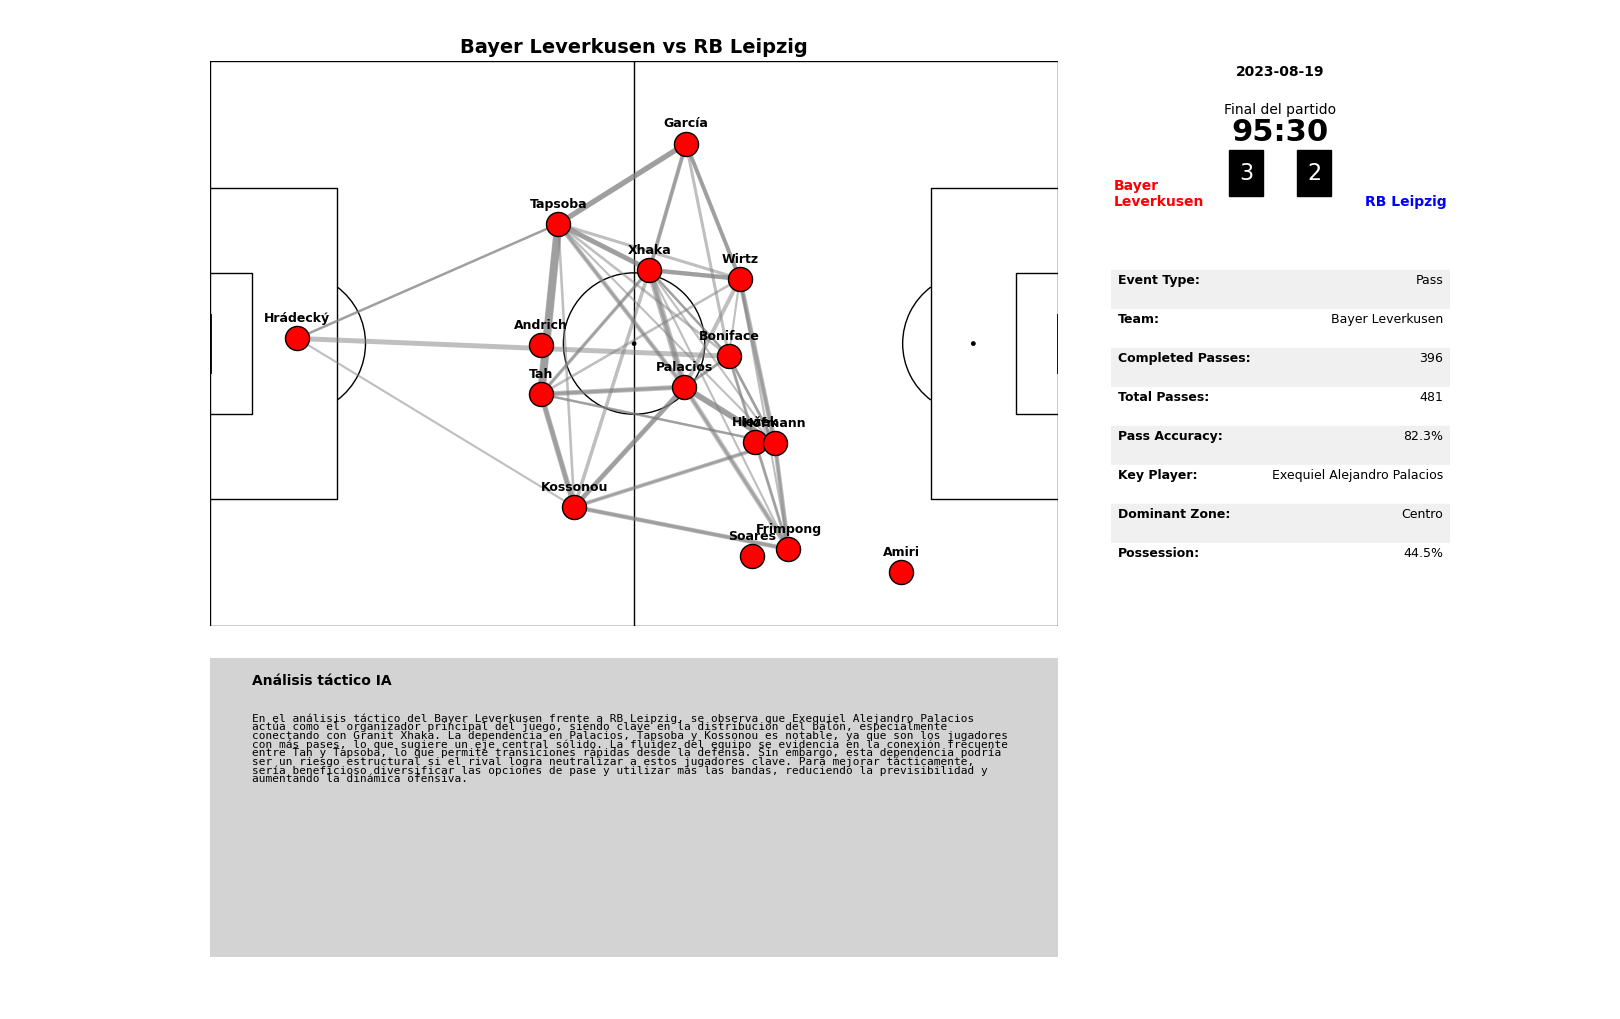

In [48]:
match_id = 3895052
equipo = "Bayer Leverkusen"

fig, texto_ia, prompt = analisis_red_completo(df, match_id=match_id, equipo=equipo)
# Crear ruta de salida
output_path = Path("../figs/red_pases") / f"red_pases_{match_id}.png"
output_path.parent.mkdir(parents=True, exist_ok=True)

fig.savefig(output_path, dpi=300, bbox_inches='tight')

print(prompt)

img_base64 = imagen_base64_red_pases(df, match_id=match_id, equipo=equipo)

output_path = Path("../figs/red_pases") / f"imagen_base64_red_pases_{match_id}.png"
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, "wb") as f:
    f.write(base64.b64decode(img_base64))